In [1]:
!pip install neuromancer

In [113]:
import neuromancer
from neuromancer.psl.building_envelope import BuildingEnvelope
import functools
from neuromancer.dataset import DictDataset
from tqdm import tqdm
import random
from torch import tensor
import torch
import numpy as np
from torch.utils.data import DataLoader
from neuromancer.modules import blocks
from neuromancer.modules.activations import activations
from neuromancer.system import Node, System
from neuromancer.constraint import variable
from neuromancer.problem import Problem
from neuromancer.loss import PenaltyLoss
from neuromancer.trainer import Trainer
from neuromancer.loggers import BasicLogger
import torch.optim as optim
import matplotlib.pyplot as plt
import os
import yaml
from dpc_util import simulate, stack_refs, load_stats, remove_key_prefix

# Objective
This tutorial demonstrates the use of Whitebox differentiable predictive control (DPC) to learn a constrained neural policy for controlling indoor air temperature in a residential building model. Blackbox DPC is a technique used when we have access to the true dynamics of the system. We train a controller to make optimial choices on the true system.

We begin by making some modifications to `BuildingEnvelope`. We remove `@cast_backend` from `get_q` to prevent casting.

In [36]:
class GradBuildingEnvelope(BuildingEnvelope):
    def __init__(self, device=None, *args, **kwargs):
        self.device=device
        super().__init__(*args, **kwargs)

    def get_q(self, u):
        m_flow = u[0:self.n_mf]
        dT = u[self.n_mf:self.n_mf + self.n_dT]
        q = m_flow * self.rho * self.cp * self.time_reg * dT
        return q

systems = {system: functools.partial(GradBuildingEnvelope, system=system) for system in BuildingEnvelope.systems}

Choose a system and device.

In [37]:
# supported systems: ['SimpleSingleZone', 'Reno_full']
psl_key = 'SimpleSingleZone'
psl_sys = systems[psl_key]()

# select appropriate device for runtime
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

 We normalize $(y, u, d)$ based on saved normalization constants.

In [38]:
NV = load_stats(psl_sys, psl_key)
NVD = {k: v.to(device) for k, v in NV.items()}

We define functions for using the normalization constants previously loaded.

In [39]:
def denorm(x, key, cpu=True):
  normer = NV if cpu else NVD
  return normer[f'{key}_min'] + (normer[f'{key}_max'] - normer[f'{key}_min']) * (x+1)/2

def norm(x, key, cpu=True):
  normer = NV if cpu else NVD
  return 2 * (x - normer[f'{key}_min']) / (normer[f'{key}_max'] - normer[f'{key}_min']) - 1

# Control
## Dataset
Our dataset is comprised of initial conditions and time-varying temperature bounds. Over time the bounds
periodically jump between a tighter, occupied-period bounds of 22$^\circ$C-24$^\circ$C, and looser, unoccupied-period bounds of 18$^\circ$C-24.4$^\circ$C, alternating with a fixed probability of 0.0005 per timestep. The initial state of the
system is uniformly randomly sampled between historical recorded min and max values, the same ones used for normalization. Let $C_k$ denote a pair of values: the lower ($C^{(\ell)}$) and upper bounds ($C^{(u)}$) at time $k$. 

In [40]:
def sample_min_max(
        nsim=20,
        prob=0.0005,
        bounds=[(20, 22), (18, 24.4)],
        nsteps=3500
        ):
    """
    :param growth_rate: (float) The rate at which the cumulative probability grows at each timestep. Default is 0.00001.
    :param max_prob: (float) The maximum probability value for changing the bounds. Default is 0.5.
    :param bounds: (list[tuple[float, float]]) A list of tuples where each tuple has two float values that represent the bounds. Default is [(20, 22), (18, 24.4)].

    :return: (numpy.ndarray) A 3D array with shape (nsim, nsteps, 2). The last dimension contains the min and max bounds respectively for each timestep in the simulation.
    """
    y_min_list = []
    y_max_list = []

    for _ in range(nsim):
        current_bound_index = random.randint(0, 1)
        y_min = np.full((nsteps,), bounds[current_bound_index][0], dtype=np.single)
        y_max = np.full((nsteps,), bounds[current_bound_index][1], dtype=np.single)

        for t in range(nsteps):
            if random.random() < prob:
                current_bound_index = 1 - current_bound_index
                y_min[t:] = bounds[current_bound_index][0]
                y_max[t:] = bounds[current_bound_index][1]

        y_min_list.append(y_min)
        y_max_list.append(y_max)
    y_min_3d = np.expand_dims(np.stack(y_min_list), axis=2)
    y_max_3d = np.expand_dims(np.stack(y_max_list), axis=2)
    return np.concatenate([y_min_3d,y_max_3d], axis=2)

We define functions to generate the conditions necessary for running and evaluating control. The bound lookahead $p$ specifies the number of timesteps into the future that our policy takes into account for the bounds.

In [41]:
bound_lookahead = 3

def get_control_dataset(name, nsim=20, nsteps=3500, device='cpu'):
    data = simulate(psl_sys, NV, nsim=nsim, nsteps=nsteps)
    refs = sample_min_max(nsim=nsim, nsteps=nsteps)

    data['Y'] = data['Y'][:, 0:1, :]
    data['LB'] = refs[:, :, 0:1]
    data['UB'] = refs[:, :, 1:2]

    bs = data['LB'].shape[0]
    ep_len = data['LB'].shape[1]

    return DictDataset({
            'yn': norm(data['Y'][:, 0:1, :], key='Y').to(device),
            'D': norm(data['D'], key='D').to(device),
            'LB': norm(stack_refs(data['LB'], forecast=bound_lookahead),
                                key='Y').to(device),
            'UB': norm(stack_refs(data['UB'], forecast=bound_lookahead),
                                key='Y').to(device),
            'LB_dn': stack_refs(data['LB'], forecast=bound_lookahead).to(device),
            'UB_dn': stack_refs(data['UB'], forecast=bound_lookahead).to(device),
            'xn_dn': data['X'][:, 0:1, :].to(device),
            'Dhidden_dn': data['Dhidden'].to(device)
        },
        name=name
    )

Now, we can generate the datasets.

In [42]:
train_data = get_control_dataset('train', nsim=64, device=device)
dev_data = get_control_dataset('dev', nsim=16, device=device)

Building data...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 10.71it/s]


Finally, define the dataloaders to be used by the `Trainer`.

In [43]:
train_loader = DataLoader(
    train_data,
    batch_size=64,
    collate_fn=train_data.collate_fn,
    shuffle=True
)

dev_loader = DataLoader(
    dev_data,
    batch_size=64,
    collate_fn=dev_data.collate_fn,
    shuffle=False
)


## Policy Inputs and Outputs
Our control policy $\pi_\phi$ will be an MLP with parameters $\phi$, that produces control outputs given the observable state, disturbances, and bounds:
$$\pi_\phi = (y_k, d_k, C_{k:k+p}) \rightarrow (u_k).$$
For convenience we denote the sequence of time bounds from $k$ to $k+p$, inclusive, as follows: $C_{k:k+p} = C_k, C_{k+1}, \dots, C_{k+p}$. 
Our bound lookahead is relatively short, at $p=3$ timesteps. This means that our policy will not have time to plan for expected bounds hours in advance, but is given some leeway to react to imminent changes.

In [44]:
hsize = 128
nlayers = 2
ny, nu, nd = psl_sys.ny, psl_sys.nU, psl_sys.nD_obs

policy = blocks.MLP_bounds(
    insize=ny + bound_lookahead * 2 + nd,
    outsize=nu,
    hsizes=[hsize for _ in range(nlayers)],
    nonlin=activations['relu'],
    linear_map=torch.nn.Linear,
    min=-1.,
    max=0.
).to(device)

As described in the following section, our policy will will aim to minimize the sum of three components: the energy usage of the control, the difference between consecutive controls, and the constraint violation penalty. Of these elements, the constraint violation penalty is weighted the highest, to ensure proper temperatures above all.

## DPC Problem Formulation  
We learn the neural control policy by solving the following parametric optimal control problem:
$$
\begin{align}
&\underset{\phi}{\text{minimize}}     &&     \mathcal{L}(u_{1:N}^{1:m}, x_{1:N}^{1:m}) = \frac{1}{Nm} \sum_{i=1}^m \sum_{k=1}^{N} \big(E(u_k^i) + \Delta U(u_k^i, u_{k-1}^i) + c(y_k^i)\big), \\
&\text{subject to}                     && u_k^i = \pi_{\phi}(y_k^i, d^i_k, C^i_{k:k+p}) \\
%&                     && \Delta U(u_k, u_{k-1}) = \frac{||\tilde{u}_k-\tilde{u}_{k-1}||_1}{N_u} \in [0,1],\\
%&                     && c_z(y) =
%\begin{cases}
%  0 & \text{if } C_\ell \leq y_z \leq C_u \\
% y_z-C_u & \text{if } y_z>C_u \\
%  C_\ell -y_z & \text{if } y_z<C_\ell
%\end{cases} \\
%&                     && y^i_0 \sim \mathcal{P}_{y_0} \\
%&                     && C \sim  \mathcal{P}_C &&
\end{align}
$$  


The objective function is to minimize a loss function comprised of three components: the energy cost of an action $E(u)$, the action stability penalty $\Delta U(u, u_{prev})$, and the constraint violation penalty $c_z(y)$, which are defined as follows:
### Energy Penalty $E(u)$
Let $q_z(u)$ denote the energy consumption $q_z$ of an individual zone $z$ upon taking action $u$. Quantity $q_z(u)$ is defined to be:
\begin{equation}
    q_z(u) = \rho c \tau_r u_{boiler} u_z,
\end{equation}
where $\rho=0.997$ is the density of water, $c=4.186$ is the specific heat capacity of water, $\tau_r=1/3600$ is the time regularization factor, $u_{boiler}$ is the boiler temperature in Celcius, and $u_z$ is the mass flow to zone $z$. The total energy $Q(u)$ of action $u$ is the sum of individual zone heat-flow energies $q_z$:
\begin{equation}
    Q(u) = \sum_{z}q_{z}(u).
\end{equation}
Finally, the energy usage term $E(u)$ is defined to be:
$$E(u) = \frac{Q(u)-Q(u_{min})}{Q(u_{max})-Q(u_{min})} \in [0,1].$$
That is, $E(u)$ is $Q(u)$ normalized such that the minimum allowable value is $0$ and the maximum is $1$. 

In the notebook code, $E(u)$ is denoted as `Q`, as the unnormalized version of `Q` makes no appearance. We define a function `u2q`, which gets $Q(u)$ from the control action $u$ and normalizes it into $E(u)$.

In [45]:
losses = []

q = variable('Q')

# loss defined as difference from zero, L1 loss
energy_loss = (q == torch.tensor(0.).to(device))
energy_loss.update_name('energy_loss')
losses.append(energy_loss)

q_min = torch.sum(psl_sys.get_q(NV['U_min']))
q_max = torch.sum(psl_sys.get_q(NV['U_max']))

def u2q(U):
    norm_u = denorm(U, key='U', cpu=False).permute(1, 0)
    denorm_q = torch.sum(psl_sys.get_q(norm_u), dim=0, keepdim=True)
    norm_q = (denorm_q - q_min) / (q_max - q_min)
    return norm_q.permute(1, 0)

q_node = Node(
    u2q,
    ['U'], ['Q'],
    name='U2Q'
)

### Action Penalty $\Delta U(u_k, u_{k-1})$

The action stability penalty is defined to be:
$$\Delta U(u_k, u_{k-1}) = \frac{||\tilde{u}_k-\tilde{u}_{k-1}||_1}{n_u} \in [0,1].$$ 
It is the average absolute distance between the action taken at the previous time step and the action taken at the current time step, averaged over the $n_u$-dimensional control vector.

In [46]:
u = variable('U')

# loss defined as difference between adjacent controls
stability_loss = ((u[:,:-1,:] - u[:,1:,:]) == torch.tensor(0.).to(device))
stability_loss.update_name('stability_loss')
losses.append(stability_loss)

### Constraint Violation Penalty $c(y)$

The per-zone constraint violation penalty, for zone $z$, based on its temperature $y_z$ is defined to be:
$$c_z(y_z) =
\begin{cases}
  0 & \text{if } C^{(\ell)} \leq y_z \leq C^{(u)} \\
  y_z-C^{(u)} & \text{if } y_z>C^{(u)} \\
  C^{(\ell)} -y_z & \text{if } y_z<C^{(\ell)}
\end{cases}.$$

if the zone temperature  is within the bounds, the penalty is zero. For all temperatures outside of the bounds, the penalty is equal to the difference between the temperature and the nearest bound. 

The overall constraint violation penalty $c(y)$ is simply the sum of the per-zone violation terms:
$$ c(y) = \sum_z c_z(y_z) $$

This can be implemented easily in neuromancer using constraints:

In [47]:
pred = variable('yn_dn')

ub = variable('UB_dn')
lb = variable('LB_dn')

# loss defined as aggregate of upper bound violation and lower bound violation
# losses are multiplied by the number of areas to sum their violations
state_upper_bound_penalty = float(ny) * (pred < ub[:, :, 0:1])
state_lower_bound_penalty = float(ny) * (pred > lb[:, :, 0:1])

constraints = [
    state_lower_bound_penalty,
    state_upper_bound_penalty
]

## Constructing the System and Problem
Now, initialize the control system. In order to allow for the system to train on GPUs, we define it as a set of parameters and equations instead of using the PSL class.




In [60]:
A = torch.tensor(psl_sys.params[2]['A'], requires_grad=False).to(device)
Beta = torch.tensor(psl_sys.params[2]['Beta'], requires_grad=False).to(device)
C = torch.tensor(psl_sys.params[2]['C'], requires_grad=False).to(device)
E = torch.tensor(psl_sys.params[2]['E'], requires_grad=False).to(device)
G = torch.tensor(psl_sys.params[2]['G'], requires_grad=False).to(device)
F = torch.tensor(psl_sys.params[2]['F'], requires_grad=False).to(device)
y_ss = torch.tensor(psl_sys.params[2]['y_ss'], requires_grad=False).to(device)

def sys_fn(x, u, d):
    x, u, d = x.T, u.T, d.T
    q = psl_sys.get_q(u)
    x = A @ x + Beta @ q + E @ d + G
    y = C @ x + F
    return x.T, y.T - y_ss

system_node = Node(sys_fn, ['xn_dn', 'U_dn', 'Dhidden_dn'], ['xn_dn', 'yn_dn'], name='system')

We will need to wrap the policy in a `Node`. We will also create a `Node` to denormalize the output of our NSSM.

In [61]:
denormnode = Node(
    lambda u:
    denorm(u, key='U'),
    ['U'], ['U_dn'],
    name='denorm'
)

normnode = Node(
    lambda yn: norm(yn, key='Y'),
    ['yn_dn'], ['yn'],
    name='norm'
)

policy_node = Node(policy, ['yn', 'D', 'UB', 'LB'], ['U'], name='policy')

system_node.eval()
control_system = System([policy_node, denormnode, system_node, normnode, q_node], name='control_system')
control_system.nstep_key = 'UB'
control_system.to(device)

System(
  (nodes): ModuleList(
    (0): policy(yn, D, UB, LB) -> U
    (1): denorm(U) -> U_dn
    (2): system(xn_dn, U_dn, Dhidden_dn) -> xn_dn, yn_dn
    (3): norm(yn_dn) -> yn
    (4): U2Q(U) -> Q
  )
)

Finally, we construct the problem.

In [62]:
obj = PenaltyLoss(losses, constraints)
problem = Problem([control_system], obj)

## Training
We define a `Trainer` and train the model, optimizing only the policy's parameters.

In [63]:
logger = BasicLogger(savedir='policy_out', stdout=['train_loss', 'dev_loss'], verbosity=1)
opt = optim.Adam(policy.parameters(), 1e-3)

trainer = Trainer(
    problem,
    train_loader,
    dev_loader,
    dev_loader,
    optimizer=opt,
    epochs=10,
    patience=5,
    train_metric="train_loss",
    eval_metric="dev_loss",
    lr_scheduler=True,
    device=device,
    logger=logger
)

None
Number of parameters: 17922


In [64]:
best_model = trainer.train()
trainer.model.load_state_dict(best_model)
problem.to('cpu')

/Users/harryqiang/Documents/TRONN/neuromancer/src/neuromancer/constraint.py:160: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([64, 3500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.l1_loss(left, right)
/Users/harryqiang/Documents/TRONN/neuromancer/src/neuromancer/constraint.py:160: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([64, 3499, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.l1_loss(left, right)
/Users/harryqiang/Documents/TRONN/neuromancer/src/neuromancer/constraint.py:160: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([16, 3500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.l1_loss(left, right)
/Users/

epoch: 0	train_loss: 0.74242	dev_loss: 0.78009	eltime:  22.17128
epoch: 1	train_loss: 0.63020	dev_loss: 0.67788	eltime:  41.08061
epoch: 2	train_loss: 0.56430	dev_loss: 0.60087	eltime:  59.89868
epoch: 3	train_loss: 0.52712	dev_loss: 0.54922	eltime:  81.17436
epoch: 4	train_loss: 0.50800	dev_loss: 0.52249	eltime:  117.81809
Interrupted training loop.


### MODEL SUMMARY ###

nodeS:
  System(
  (nodes): ModuleList(
    (0): policy(yn, D, UB, LB) -> U
    (1): denorm(U) -> U_dn
    (2): system(xn_dn, U_dn, Dhidden_dn) -> xn_dn, yn_dn
    (3): norm(yn_dn) -> yn
    (4): U2Q(U) -> Q
  )
)

CONSTRAINTS:
  Constraint(
  (left): yn_dn
  (right): slice
  (comparator): GT()
)
  Constraint(
  (left): yn_dn
  (right): slice
  (comparator): LT()
)

OBJECTIVES:
  Constraint(
  (left): Q
  (right): 5756876208
  (comparator): Eq()
)
  Constraint(
  (left): -
  (right): 5757990080
  (comparator): Eq()
)

### Evaluate Notebook or Pretrained Policy
The policy trained earlier will likely have poor performance, as a good policy for this problem typically takes longer to train. Set `use_pretrained` to `True` to load and evaluate a pre-trained model with good performance, or to `False` to use the policy trained above.

In [109]:
use_pretrained = True

if use_pretrained:
    file_root = f'models/whitebox/{psl_key}'
    with open(os.path.join(file_root, 'config.yaml'), 'r') as yaml_file:
      cfg = yaml.unsafe_load(yaml_file)
    hsize = cfg.hsize
    nlayers = cfg.nlayers
    act = cfg.act

    pt_policy = blocks.MLP_bounds(
        insize=ny + bound_lookahead * 2 + nd,
        outsize=nu,
        hsizes=[hsize for _ in range(nlayers)],
        nonlin=activations[act],
        linear_map=torch.nn.Linear,
        min=-1.,
        max=1.
    )

    problem_state_dict = torch.load(os.path.join(file_root, 'best_model_state_dict.pth'), map_location=torch.device('cpu'))

    pt_policy_node = Node(pt_policy, ['yn', 'D', 'UB', 'LB'], ['U'], name='policy')
    pt_policy_node.load_state_dict(remove_key_prefix(problem_state_dict, 'nodes.0.nodes.0.'))
    test_policy_node = pt_policy_node
else:
    test_policy_node = policy_node

test_system = System([test_policy_node, denormnode, system_node, normnode, q_node], name='control_system')
test_system.nstep_key = 'UB'

Let's evaluate now.

In [110]:
test_data_dict = get_control_dataset('test', nsim=5, device='cpu').datadict
test_system.eval()
test_system = test_system.to('cpu')
test_out = test_system(test_data_dict)

Building data...: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.82it/s]


Plot the performance of the policy on the true system.

<Figure size 640x480 with 0 Axes>

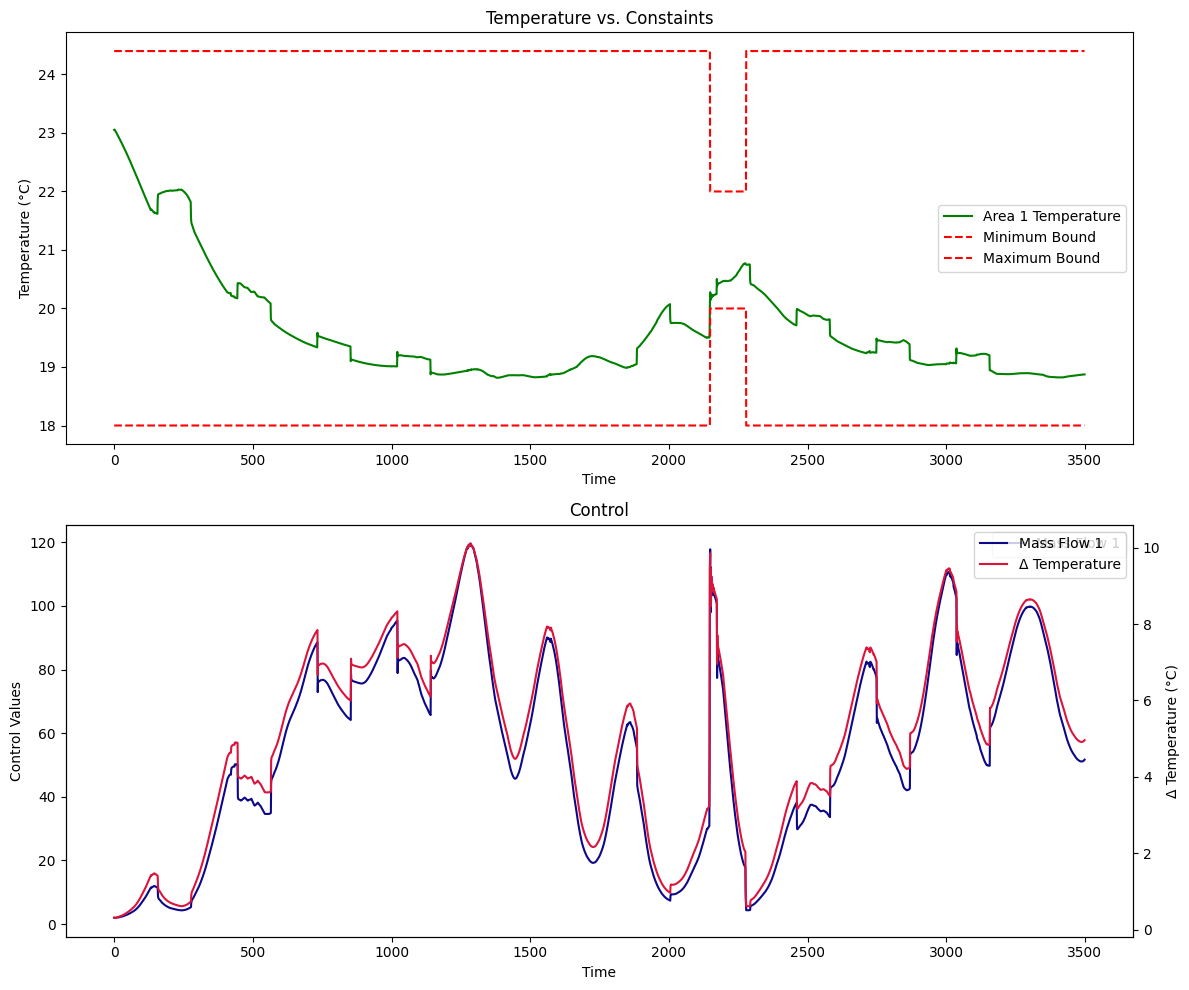

In [112]:
num_colors = 6
target_colors = [plt.cm.ocean(i / num_colors) for i in range(num_colors)]
control_colors = [plt.cm.plasma(i / num_colors) for i in range(num_colors)]

def plot_control(data, sim=0):
    plt.clf()
    plot = {}
    for key in data:
        plot[key] = data[key].detach().cpu().numpy()

    sample_temp = plot["yn_dn"][sim, :, :]
    sample_LB = plot["LB_dn"][sim, :, 0:1]
    sample_UB = plot["UB_dn"][sim, :, 0:1]
    sample_control = plot["U_dn"][sim, :, :]

    fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(12, 10))

    for v in range(sample_temp.shape[1]):
      axs[0].plot(sample_temp[:, v], label=f'Area {v+1} Temperature', color=target_colors[v])

    axs[0].plot(sample_LB, linestyle="--", label="Minimum Bound", color="red")
    axs[0].plot(sample_UB, linestyle="--", label="Maximum Bound", color="red")

    axs[0].set_title("Temperature vs. Constaints")
    axs[0].set_ylabel("Temperature (°C)")
    axs[0].set_xlabel("Time")
    axs[0].legend()

    lns = []
    for v in range(sample_control.shape[1] - 1):
        ln = axs[1].plot(sample_control[:, v], label=f'Mass Flow {v+1}', color=control_colors[v])[0]
        lns.append(ln)
    
    axs[1].set_title('Control')
    axs[1].set_xlabel('Time')
    axs[1].set_ylabel('Mass Flow (kg/s)')
    
    
    ax2 = axs[1].twinx()
    lns.append(ax2.plot(sample_control[:, -1], label='Δ Temperature', color='crimson')[0])
    ax2.set_ylabel('Δ Temperature (°C)')
    
    labs = [ln.get_label() for ln in lns]
    ax2.legend(lns, labs, loc=1)

    axs[1].set_title('Control')
    axs[1].set_xlabel('Time')
    axs[1].set_ylabel('Control Values')
    axs[1].legend()

    plt.tight_layout()
    plt.show()


plot_control(test_out, sim=0)